Original circuit:


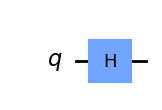

Auxiliary circuit for X


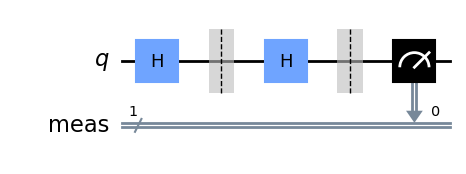

Auxiliary circuit for Z


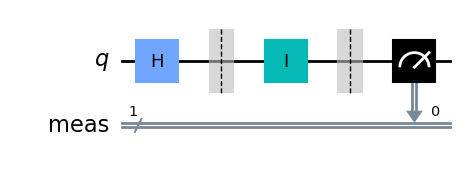

In [1]:
from qiskit import QuantumCircuit
from qiskit.quantum_info import SparsePauliOp

# The following code will work for any other initial single-qubit state and observable
original_circuit = QuantumCircuit(1)
original_circuit.h(0)

H = SparsePauliOp(["X", "Z"], [2, -1])

aux_circuits = []
for pauli in H.paulis:
    aux_circ = original_circuit.copy()
    aux_circ.barrier()
    if str(pauli) == "X":
        aux_circ.h(0)
    elif str(pauli) == "Y":
        aux_circ.sdg(0)
        aux_circ.h(0)
    else:
        aux_circ.i(0)
    aux_circ.measure_all()
    aux_circuits.append(aux_circ)


print("Original circuit:")
display(original_circuit.draw("mpl"))
for (circuit, pauli) in zip(aux_circuits, H.paulis):
    print(f"Auxiliary circuit for {str(pauli)}")
    display(circuit.draw("mpl"))

In [2]:
from qiskit.primitives import Sampler, Estimator
from qiskit.circuit.library import IGate, ZGate
import numpy as np


## SAMPLER
sampler = Sampler()
job = sampler.run(aux_circuits)
probability_dists = job.result().quasi_dists
probability_dists = [np.array([[dist.get(0,0), dist.get(1,0)]]) for dist in probability_dists]

expvals = []
for dist, pauli in zip(probability_dists, H.paulis):
    val = 0
    if str(pauli) == "I":
        Lambda = IGate().to_matrix().real
    else:
        Lambda = ZGate().to_matrix().real
    val += dist @ Lambda @ dist.transpose()
    expvals.append(val)


print("Sampler results:")
for (pauli, expval) in zip(H.paulis, expvals):
    print(f"  >> Expected value of {str(pauli)}: {expval.item():.5f}")

total_expval = np.sum(H.coeffs * expvals).real
print(f"  >> Total expected value: {total_expval:.5f}")


## ESTIMATOR
observables = [
    *H.paulis,
    H,
]  # Note: run for individual Paulis as well as full observable H

estimator = Estimator()
print(original_circuit)
print(observables)
job = estimator.run([original_circuit] * len(observables), observables)
# prepare in reference state for every observables in the list "observables"
estimator_expvals = job.result().values

print("Estimator results:")
for (obs, expval) in zip(observables, estimator_expvals):
    if obs is not H:
        print(f"  >> Expected value of {str(obs)}: {expval:.5f}")
    else:
        print(f"  >> Total expected value: {expval:.5f}")

Sampler results:
  >> Expected value of X: 1.00000
  >> Expected value of Z: 0.00000
  >> Total expected value: 1.00000
   ┌───┐
q: ┤ H ├
   └───┘
[Pauli('X'), Pauli('Z'), SparsePauliOp(['X', 'Z'],
              coeffs=[ 2.+0.j, -1.+0.j])]
Estimator results:
  >> Expected value of X: 1.00000
  >> Expected value of Z: 0.00000
  >> Total expected value: 2.00000


## Overhead of realizing circuit on quantum hardwware

### [Error supression (Compilation)](https://qiskit.org/ecosystem/ibm-runtime/how_to/error-suppression.html)

+ Expressing the circuit using the native gates available on a quantum system
+ Mapping the virtual qubits to physical qubits
+ Adding SWAPs based on connectivity requirements
+ Optimizing 1Q and 2Q gates
+ Adding dynamical decoupling to idle qubits to prevent the effects of decoherence.

Primitives allow for the use of error suppression techniques by setting the optimization_level option and selecting advanced transpilation options.

Primitives (qiskit.primitives) are core functions that make it easier to build modular algorithms and applications. 

### [Error mitigation (execution)](https://qiskit.org/ecosystem/ibm-runtime/how_to/error-mitigation.html)

Error mitigation techniques allow users to mitigate circuit errors by modeling the device noise at the time of execution. This typically results in quantum pre-processing overhead related to model training and classical post-processing overhead to mitigate errors in the raw results by using the generated model.

List of error mitigation techniques :
+ Twirled readout error extinction (T-REx)
+ Zero noise extrapolation
+ Probabilistic error cancellation
